In [3]:
#### Reference paper https://arxiv.org/abs/1808.08219

#### Keeping tau_i fixed and then calculating y_i as per the value of 
#### tau_i.


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


# Reference paper https://arxiv.org/abs/1808.08219
# Referencing from Eq.(3.2) to Eq.(3.7) in https://arxiv.org/abs/1808.08219
# Only using the dimensionless equations
# Using PBH as the sole source og Gravitational potential
# Explicitly adding Hubble expansion (or deceleration term) in RD with H(t)=1/2t
# so that v_i = H r_i .
# Using either solve_ivp or adaptive integrator as the differential equation solver


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg



def j_fdm_hubble(t, y, gamma):
    r, dydtau = y
    dydtau2 =  - r/(4 * (t**2))
    return [dydtau, dydtau2]


def j_fdm(t, y, gamma):   #j_fdm_full(t, y)
    r, dydtau = y
    dydtau2 = (2*gamma - (gamma**2))/(4*(r**3)) - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]
 

def j_fdm_pbh(t, y, gamma):
    r, dydtau = y
    A = tau_i/(y_i**2)
    B = ((2*gamma - gamma**2) * (tau_i**(3/2)))/(4 * (y_i**3))
    dydtau2 =  - (A/t) + (B/(t**(3/2)))
    return [dydtau, dydtau2]
    

def j_cdm(t, y, gamma):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y, gamma):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y, gamma):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)


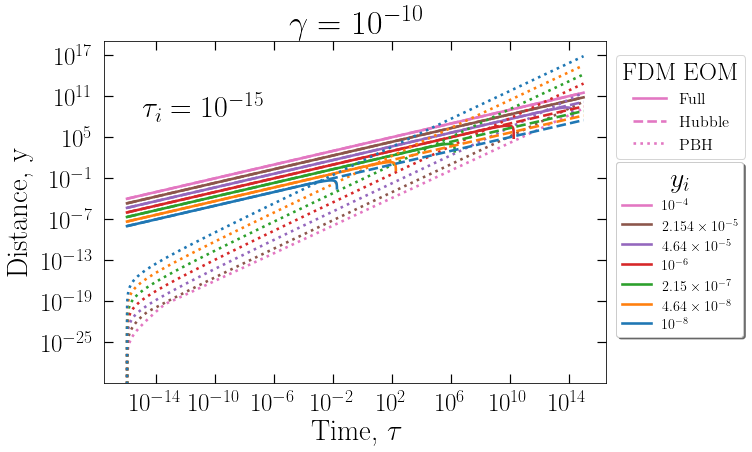

In [38]:
fig, ax = plt.subplots(1, figsize=(9, 6.3))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')




gamma = 1e-10
tau_f = 1e15
yi_arr = np.geomspace(1e-4, 1e-8, 7)



colors = ['C6','C5','C4', 'C3', 'C2', 'C1', 'C0'] 
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    tau_i = 1e-16      
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm_full = solve_ivp(j_fdm, [tau_i, tau_f], y0, args = (gamma,),  t_eval=tau_arr, method='RK45',
        rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])

    sol_fdm_hubble = solve_ivp(j_fdm_hubble, [tau_i, tau_f], y0, args = (gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])

    
    y_i_pbh = 0
    v_i_pbh = 0 
    y0_pbh = [y_i_pbh, v_i_pbh]

    sol_fdm_pbh = solve_ivp(j_fdm_pbh, [tau_i, tau_f], y0_pbh, args = (gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-6, atol=1e-8)

    
    
    ax.loglog(sol_fdm_full.t, sol_fdm_full.y[0], color = color)
    ax.loglog(sol_fdm_hubble.t, sol_fdm_hubble.y[0],  color = color, ls ='--')
    ax.loglog(sol_fdm_pbh.t, -sol_fdm_pbh.y[0],  color = color, ls =':')
   
    
 
    
ax.tick_params(axis ='x', pad = 9.9)
ax.tick_params(axis ='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1, 2]], ["Full", "Hubble", "PBH"], title = 'FDM EOM',
        title_fontsize = 25, loc = (1.02, 0.655), prop = {"size":16.3})
legend2 = plt.legend([lines[i] for i in [0, 3, 6, 9, 12, 15, 18]], [  
              r'$10^{-4}$', r'$ 2.154\times10^{-5}$', r'$4.64\times10^{-5}$', r'$10^{-6}$',r'$2.15\times10^{-7}$',
                r'$4.64\times10^{-8}$',  r'$10^{-8}$'                                                  
              ],prop = {'size':14.2},
              loc = (1.02, 0.135),shadow = True, title = '$y_{i}$' ,title_fontsize = 28,
           facecolor = 'white',fontsize = 28)


ax.add_artist(legend1)
ax.add_artist(legend2)

plt.text(1e-15, 1e8, r'$\tau_i = 10^{-15}$', fontsize = 30)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=29)
plt.ylabel('Distance, y', fontsize=29, labelpad=9)
plt.title(r'$\gamma = 10^{-10}$', fontsize = 34)
plt.savefig('test1.pdf', bbox_inches = 'tight')
plt.show()

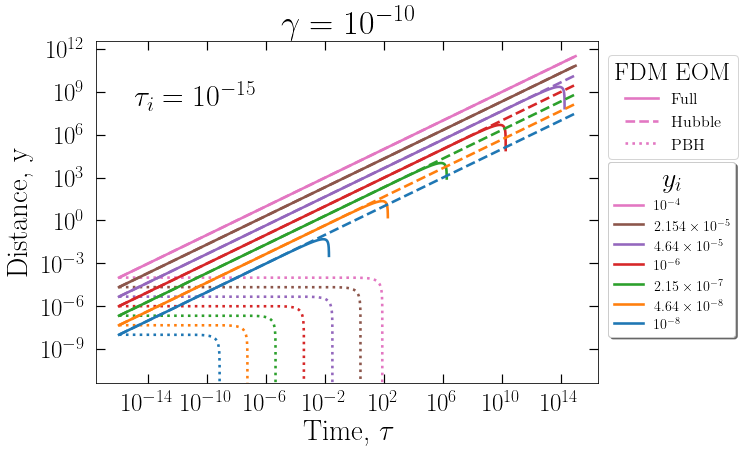

In [40]:
fig, ax = plt.subplots(1, figsize=(9, 6.3))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')




gamma = 1e-10
tau_f = 1e15
yi_arr = np.geomspace(1e-4, 1e-8, 7)



colors = ['C6','C5','C4', 'C3', 'C2', 'C1', 'C0'] 
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    tau_i = 1e-16      
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm_full = solve_ivp(j_fdm, [tau_i, tau_f], y0, args = (gamma,),  t_eval=tau_arr, method='RK45',
        rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])

    sol_fdm_hubble = solve_ivp(j_fdm_hubble, [tau_i, tau_f], y0, args = (gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])

    
    y_i_pbh = y_i
    v_i_pbh = 0 
    y0_pbh = [y_i_pbh, v_i_pbh]

    sol_fdm_pbh = solve_ivp(j_fdm_pbh, [tau_i, tau_f], y0_pbh, args = (gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-6, atol=1e-8)

    
    
    ax.loglog(sol_fdm_full.t, sol_fdm_full.y[0], color = color)
    ax.loglog(sol_fdm_hubble.t, sol_fdm_hubble.y[0],  color = color, ls ='--')
    ax.loglog(sol_fdm_pbh.t, sol_fdm_pbh.y[0],  color = color, ls =':')
   
    
 
    
ax.tick_params(axis ='x', pad = 9.9)
ax.tick_params(axis ='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1, 2]], ["Full", "Hubble", "PBH"], title = 'FDM EOM',
        title_fontsize = 25, loc = (1.02, 0.655), prop = {"size":16.3})
legend2 = plt.legend([lines[i] for i in [0, 3, 6, 9, 12, 15, 18]], [  
              r'$10^{-4}$', r'$ 2.154\times10^{-5}$', r'$4.64\times10^{-5}$', r'$10^{-6}$',r'$2.15\times10^{-7}$',
                r'$4.64\times10^{-8}$',  r'$10^{-8}$'                                                  
              ],prop = {'size':14.2},
              loc = (1.02, 0.135),shadow = True, title = '$y_{i}$' ,title_fontsize = 28,
           facecolor = 'white',fontsize = 28)


ax.add_artist(legend1)
ax.add_artist(legend2)

plt.text(1e-15, 1e8, r'$\tau_i = 10^{-15}$', fontsize = 30)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=29)
plt.ylabel('Distance, y', fontsize=29, labelpad=9)
plt.title(r'$\gamma = 10^{-10}$', fontsize = 34)
plt.savefig('test2.pdf', bbox_inches = 'tight')
plt.show()